# E-commerce Customers Segmentation

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import ipywidgets as widgets
from IPython.display import display, Markdown
from matplotlib import gridspec 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')
import datetime as dt


In [50]:
customers = pd.read_excel('E-commerce_data.xlsx', sheet_name='customers')
customers


,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1
...,...,...,...,...
995,996,2022-10-28,3,1
996,997,2022-07-07,20,2
997,998,2024-03-09,11,2
998,999,2022-07-16,6,1


In [51]:
genders = pd.read_excel('E-commerce_data.xlsx', sheet_name='genders')
genders

,gender_id,gender_name
0,1,Male
1,2,Female


In [52]:
cities = pd.read_excel('E-commerce_data.xlsx', sheet_name='cities')
cities

,city_id,city_name
0,1,Cairo
1,2,Alexandria
2,3,Giza
3,4,Shubra El-Kheima
4,5,Port Said
5,6,Suez
6,7,Mansoura
7,8,El-Mahalla El-Kubra
8,9,Tanta
9,10,Asyut


In [53]:
transactions = pd.read_excel('E-commerce_data.xlsx', sheet_name='transactions')
transactions

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6
...,...,...,...,...,...,...,...
4995,4996,776,2024-03-20,subscribed,OSq-518,NaT,1
4996,4997,583,2024-06-27,subscribed,FsJ-607,NaT,2
4997,4998,504,2022-11-08,burned,WcY-330,2022-12-06,2
4998,4999,876,2024-05-05,burned,bgx-731,2024-07-29,7


In [54]:
branches = pd.read_excel('E-commerce_data.xlsx', sheet_name='branches')
branches

,branch_id,merchant_id
0,1,11
1,2,18
2,3,8
3,4,15
4,5,9
5,6,15
6,7,7
7,8,20
8,9,13
9,10,13


In [55]:
merchants = pd.read_excel('E-commerce_data.xlsx', sheet_name='merchants')
merchants

,merchant_id,merchant_name
0,1,Rivas Group
1,2,Peters-Acosta
2,3,"Duran, Perry and Stout"
3,4,Morton Ltd
4,5,Curtis-Fields
5,6,Armstrong-Gutierrez
6,7,Berry-Anderson
7,8,Medina-Foster
8,9,"Campbell, Shaffer and Martinez"
9,10,"Adams, Cruz and Williams"


## Feature selection

In [56]:
# Merge the tables
# (on = " " )-> the connection between the two data frames is in this column , 
#(how = " ")-> that the merge will take all columns for the first data frame and the new ones in the second (left joint)
customers = customers.merge(genders, on='gender_id', how='left')
customers = customers.merge(cities, on='city_id', how='left')
data = transactions.merge(customers, on='customer_id', how='left')
data.head(5)

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_id,gender_id,gender_name,city_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,2023-05-16,15,2,Female,Aswan
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,2022-10-10,14,2,Female,Damietta
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,2022-05-30,2,1,Male,Alexandria
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,2023-11-27,15,2,Female,Aswan
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,2021-09-04,14,1,Male,Damietta


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   join_date           5000 non-null   datetime64[ns]
 8   city_id             5000 non-null   int64         
 9   gender_id           5000 non-null   int64         
 10  gender_name         5000 non-null   object        
 11  city_name           5000 non-null   object        
dtypes: datetime64[ns](3), int64(5), object(4)
memory usage: 468.9+ KB


In [58]:
data["burn_date"].isnull().sum()

2484

In [59]:
# fill missing values in one column with values from another column based on the same index.
data['burn_date'] = data['burn_date'].fillna(data['transaction_date'])
data.sample(5)

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,join_date,city_id,gender_id,gender_name,city_name
2475,2476,290,2024-06-14,subscribed,URQ-696,2024-06-14,6,2023-11-13,3,2,Female,Giza
3462,3463,419,2023-10-12,subscribed,Nkn-937,2023-10-12,8,2023-06-22,11,1,Male,Ismailia
470,471,676,2023-05-22,subscribed,GNc-557,2023-05-22,9,2021-09-04,19,1,Male,Qena
2668,2669,852,2022-11-24,burned,flK-443,2023-01-09,5,2022-09-22,11,2,Female,Ismailia
3452,3453,800,2024-03-02,burned,kcT-398,2024-03-31,10,2022-07-14,2,2,Female,Alexandria


In [60]:
# check duplicates
duplicates = data.duplicated().sum()
duplicates

0

### Perform RFM

In [61]:
# Assuming 'transaction_date' is the date of the transaction
current_date = dt.datetime.now()
recency_df = data.groupby('customer_id')['transaction_date'].max().reset_index()
recency_df.columns = ['customer_id', 'last_purchase_date']
recency_df['recency'] = (current_date - recency_df['last_purchase_date']).dt.days


In [62]:
frequency_df = data.groupby('customer_id')['transaction_id'].count().reset_index()
frequency_df.columns = ['customer_id', 'frequency']


In [63]:
# Calculate Monetary using total transactions
monetary_df = data.groupby('customer_id')['transaction_id'].count().reset_index()
monetary_df.columns = ['customer_id', 'monetary']


In [64]:
# Merge RFM metrics
rfm_df = recency_df.merge(frequency_df, on='customer_id')
rfm_df = rfm_df.merge(monetary_df, on='customer_id')

In [65]:
# Assign RFM scores
#rfm_df['R_rank'] = rfm_df['recency'].rank(ascending=False)
#rfm_df['F_rank'] = rfm_df['frequency'].rank(ascending=True)
#rfm_df['M_rank'] = rfm_df['monetary'].rank(ascending=True)

In [66]:
rfm_df['r_quartile'] = pd.qcut(rfm_df['recency'], 4, ['1','2','3','4'])
rfm_df['f_quartile'] = pd.qcut(rfm_df['frequency'], 4, ['4','3','2','1'])
rfm_df['m_quartile'] = pd.qcut(rfm_df['monetary'], 4, ['4','3','2','1'])
print(rfm_df.head())

   customer_id last_purchase_date  recency  frequency  monetary r_quartile  \
0            1         2024-05-26      119          7         7          2   
1            2         2023-10-21      337          3         3          4   
2            3         2024-07-05       79          5         5          1   
3            4         2023-01-15      616          1         1          4   
4            5         2024-07-02       82          4         4          1   

  f_quartile m_quartile  
0          1          1  
1          4          4  
2          3          3  
3          4          4  
4          3          3  


In [67]:
rfm_df['RFM_Score'] = rfm_df.r_quartile.astype(str)+ rfm_df.f_quartile.astype(str) + rfm_df.m_quartile.astype(str)
print(rfm_df.head())

   customer_id last_purchase_date  recency  frequency  monetary r_quartile  \
0            1         2024-05-26      119          7         7          2   
1            2         2023-10-21      337          3         3          4   
2            3         2024-07-05       79          5         5          1   
3            4         2023-01-15      616          1         1          4   
4            5         2024-07-02       82          4         4          1   

  f_quartile m_quartile RFM_Score  
0          1          1       211  
1          4          4       444  
2          3          3       133  
3          4          4       444  
4          3          3       133  


In [68]:
print(rfm_df[rfm_df['RFM_Score']=='111'].sort_values('monetary',ascending
=False).head())
print(rfm_df.columns)

     customer_id last_purchase_date  recency  frequency  monetary r_quartile  \
812          822         2024-07-14       70         14        14          1   
716          726         2024-07-14       70         13        13          1   
69            73         2024-07-12       72         12        12          1   
566          573         2024-07-01       83         11        11          1   
150          154         2024-07-11       73         11        11          1   

    f_quartile m_quartile RFM_Score  
812          1          1       111  
716          1          1       111  
69           1          1       111  
566          1          1       111  
150          1          1       111  
Index(['customer_id', 'last_purchase_date', 'recency', 'frequency', 'monetary',
       'r_quartile', 'f_quartile', 'm_quartile', 'RFM_Score'],
      dtype='object')


### EDA

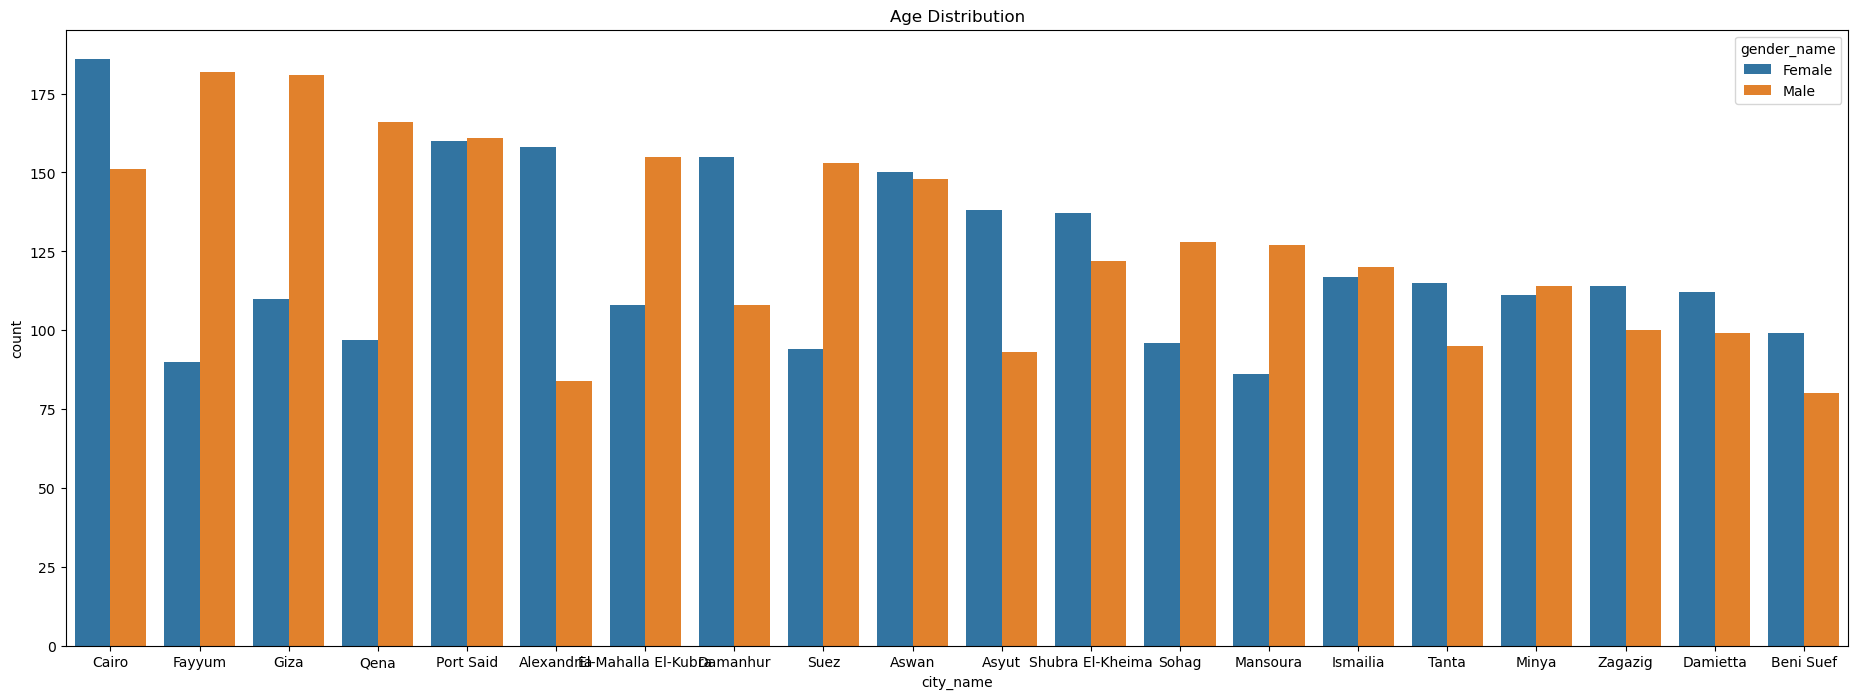

In [69]:
# gender & city 
gender_city_data = data[['gender_name', 'city_name']].value_counts().reset_index().sort_values(ascending=False, by='count')
# visualize  city && gender
plt.figure(figsize=(23, 8))
sns.barplot(data=gender_city_data, x='city_name', y='count', hue='gender_name')
plt.title("Age Distribution")
plt.show()

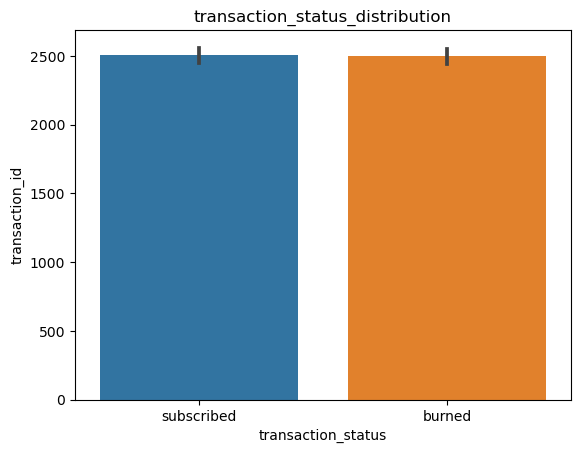

In [70]:
# transaction state 
sns.barplot(data=data, x='transaction_status', y='transaction_id')
plt.ylabel('transaction_id')
plt.title('transaction_status_distribution')
plt.show()

### the day that has the highest number of transaction 

In [71]:
transaction_counts = data.groupby('transaction_date')['transaction_id'].count().reset_index()
transaction_counts.columns = ['transaction_date', 'transaction_count']
max_transaction_date = transaction_counts.loc[transaction_counts['transaction_count'].idxmax(), 'transaction_date']
print(f"The date with the highest number of transactions is: {max_transaction_date}")


The date with the highest number of transactions is: 2024-07-12 00:00:00


### gender & subscribe relation insights 

In [72]:
#gender & subscribe relation insights 
gender_transaction_counts = data.groupby(['gender_name', 'transaction_status']).size().reset_index(name='counts')
print(gender_transaction_counts)


  gender_name transaction_status  counts
0      Female             burned    1231
1      Female         subscribed    1202
2        Male             burned    1285
3        Male         subscribed    1282


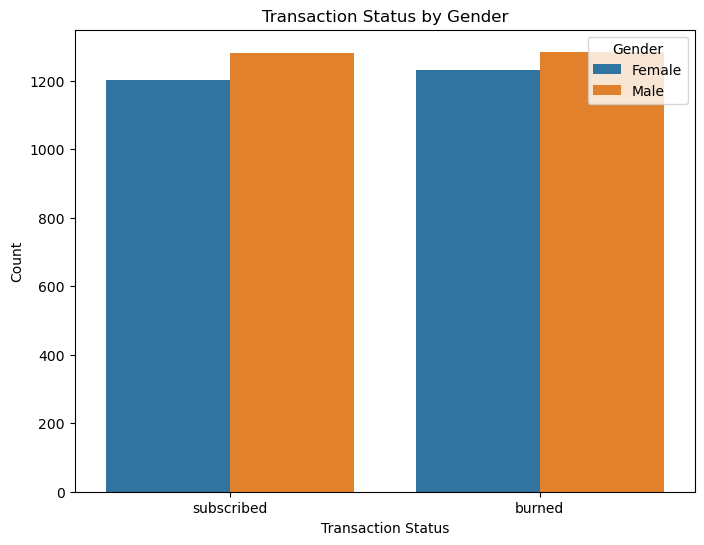

In [73]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='transaction_status', hue='gender_name')
plt.title('Transaction Status by Gender')
plt.xlabel('Transaction Status')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()


### building kmeans model 

In [74]:
scaler = StandardScaler()
numeric_data = data.select_dtypes(include=[np.number])
data_scaled = scaler.fit_transform(numeric_data)


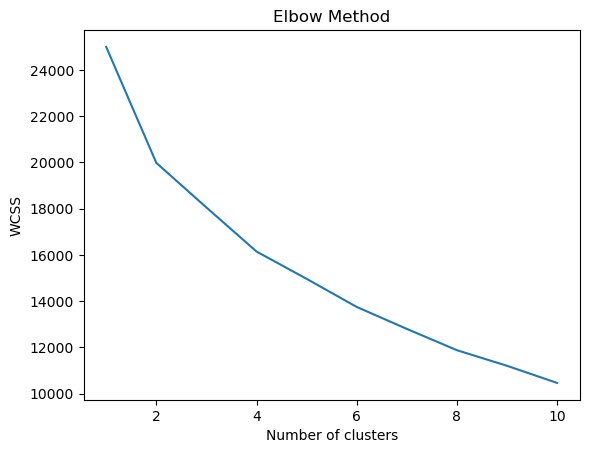

In [75]:

data_fit = scaler.fit_transform(data_scaled)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


   Cluster
0        1
1        1
2        0
3        1
4        0


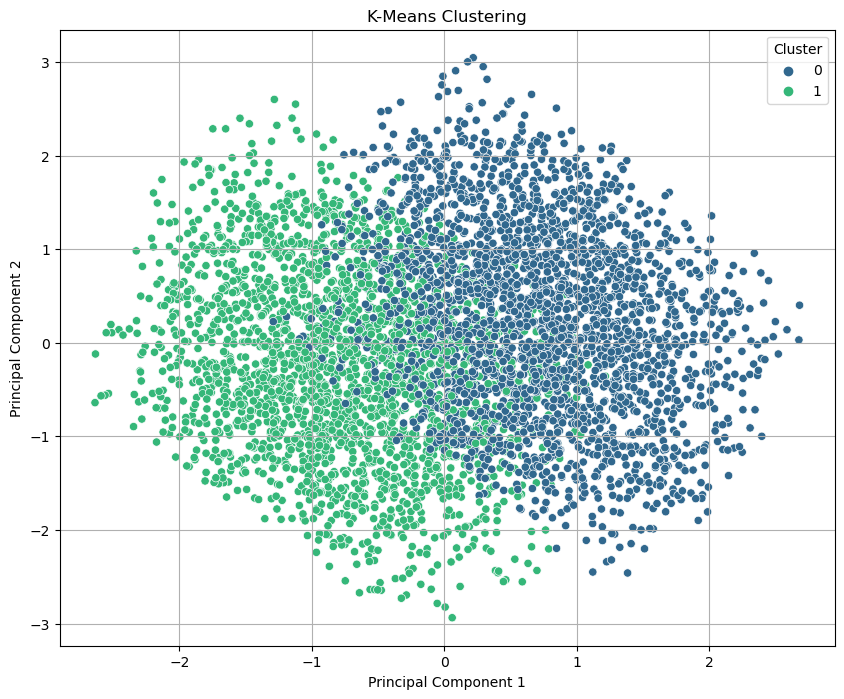

In [76]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_fit)
data['Cluster'] = kmeans.labels_
# Print the clusters
print(data[['Cluster']].head())

# Visualize the clusters using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Create DataFrame with PCA components and cluster labels
df_clusters = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
df_clusters['Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_clusters, palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## Model Evalution

Silhouette Score:The silhouette score measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a higher value indicates better-defined clusters.

Davies-Bouldin Index:The Davies-Bouldin index evaluates the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering separation.

Calinski-Harabasz Index:measures the ratio of the sum of between-cluster dispersion and within-cluster dispersion. Higher values generally indicate better cluster quality and separation.


In [77]:
# Evaluate the Model
silhouette = silhouette_score(data_scaled, kmeans.labels_)
inertia = kmeans.inertia_
db_score = davies_bouldin_score(data_scaled, kmeans.labels_)
ch_score = calinski_harabasz_score(data_scaled, kmeans.labels_)

print(f'Silhouette Score: {silhouette}')
print(f'Inertia: {inertia}')
print(f'Davies-Bouldin Index: {db_score}')
print(f'Calinski-Harabasz Index: {ch_score}')


Silhouette Score: 0.2101218283222841
Inertia: 19983.96785674207
Davies-Bouldin Index: 1.9407953145554497
Calinski-Harabasz Index: 1254.5120584521167


#### results shows that :
A score of 0.171 suggests that the clusters are not very well-defined. There might be some overlap between clusters, indicating that the model could be improved.

A value of 0.986 indicates relatively good separation between clusters. However, there is still room for improvement to achieve better-defined clusters.

A value of 1254 suggests that the clusters are reasonably well-separated and cohesive. This is a positive indicator of the clustering quality.

In [78]:
data = data[['transaction_id', 'customer_id', 'transaction_date', 'transaction_status', 'coupon_name', 'burn_date', 'branch_id', 'join_date', 'city_name', 'gender_name']]

# Convert dates to numerical values (e.g., days since a reference date)
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['burn_date'] = pd.to_datetime(data['burn_date'])
data['join_date'] = pd.to_datetime(data['join_date'])
reference_date = pd.Timestamp('2020-01-01')
data['transaction_date'] = (data['transaction_date'] - reference_date).dt.days
data['burn_date'] = (data['burn_date'] - reference_date).dt.days
data['join_date'] = (data['join_date'] - reference_date).dt.days




In [79]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['transaction_date', 'burn_date', 'join_date']),
        ('cat', OneHotEncoder(), ['transaction_status', 'coupon_name', 'city_name', 'gender_name'])
    ]
)

# Apply the transformations
data_preprocessed = preprocessor.fit_transform(data)


In [80]:
# Define DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=500)

# Fit the model
labels = dbscan.fit_predict(data_preprocessed)

# Add labels to the original data
data['Cluster'] = labels


####  Evaluate the Model

Cluster
-1    5000
Name: count, dtype: int64


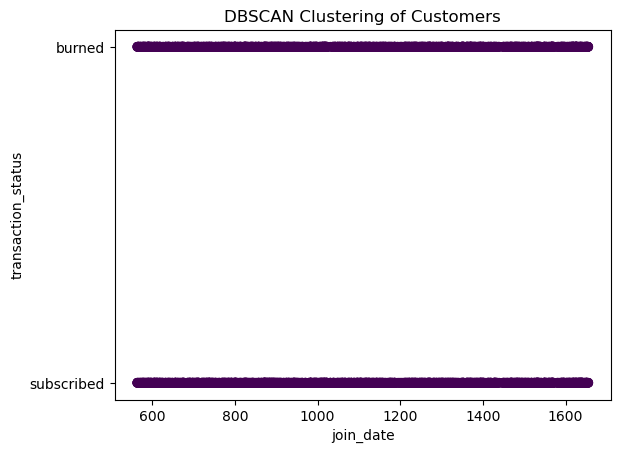

In [81]:
# Count the number of customers in each cluster
cluster_counts = data['Cluster'].value_counts()
print(cluster_counts)

plt.scatter(data['join_date'], data['transaction_status'], c=labels, cmap='viridis')
plt.xlabel('join_date')
plt.ylabel('transaction_status')
plt.title('DBSCAN Clustering of Customers')
plt.show()


### Hierarchical model 

In [89]:
data = data[['transaction_date', 'transaction_status', 'burn_date', 'join_date', 'city_name', 'gender_name']]

In [91]:
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['burn_date'] = pd.to_datetime(data['burn_date'])
data['join_date'] = pd.to_datetime(data['join_date'])
reference_date = pd.Timestamp('2020-01-01')
data['transaction_date'] = (data['transaction_date'] - reference_date).dt.days
data['burn_date'] = (data['burn_date'] - reference_date).dt.days
data['join_date'] = (data['join_date'] - reference_date).dt.days

In [93]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['transaction_date', 'burn_date', 'join_date']),
        ('cat', OneHotEncoder(), ['transaction_status', 'city_name', 'gender_name'])
    ]
)

scaler = StandardScaler()
data_preprocessed = preprocessor.fit_transform(data).toarray()

In [96]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
# Perform hierarchical clustering using complete's method
hcc = linkage(data_preprocessed, method='complete')
# Perform hierarchical clustering using ward's method
hcw = linkage(data_preprocessed, method='ward')
# Perform hierarchical clustering using single's method
hcs = linkage(data_preprocessed, method='single')
# Perform hierarchical clustering using average's method
hca = linkage(data_preprocessed, method='average')

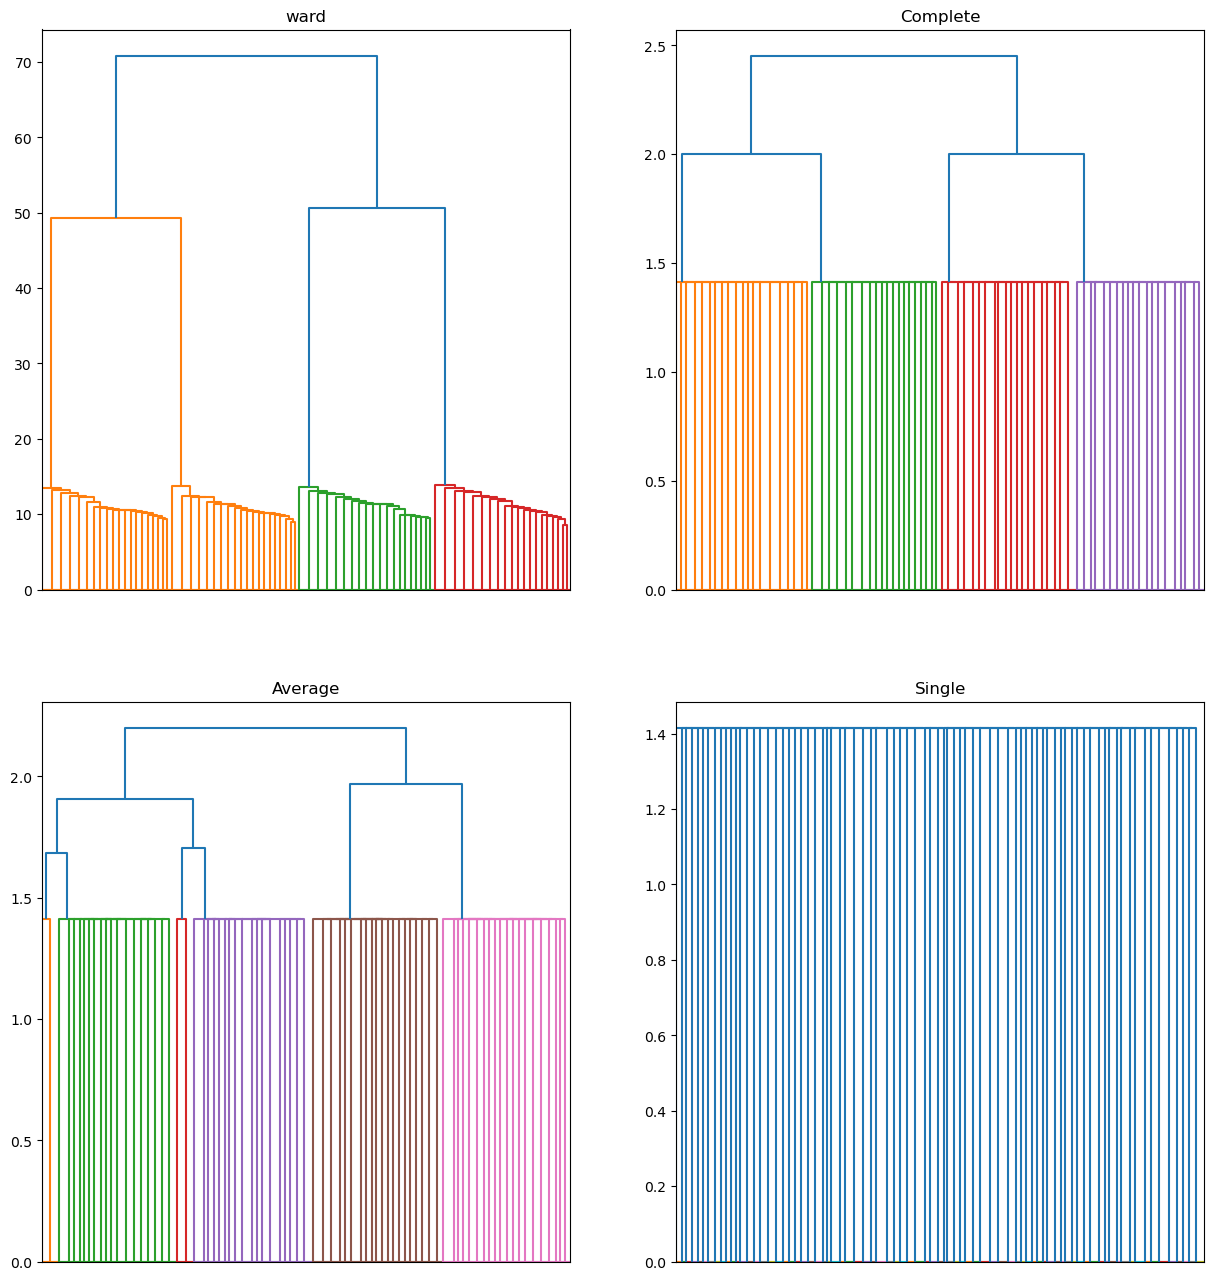

In [97]:
plt.figure(figsize=(15, 16))
plt.subplot(2,2,4), dendrogram(hcs, no_labels=True), plt.title('Single')
plt.subplot(2,2,2), dendrogram(hcc, no_labels=True), plt.title('Complete')
plt.subplot(2,2,3), dendrogram(hca, no_labels=True), plt.title('Average')
plt.subplot(2,2,1), dendrogram(hcw, no_labels=True), plt.title('ward')
plt.show()

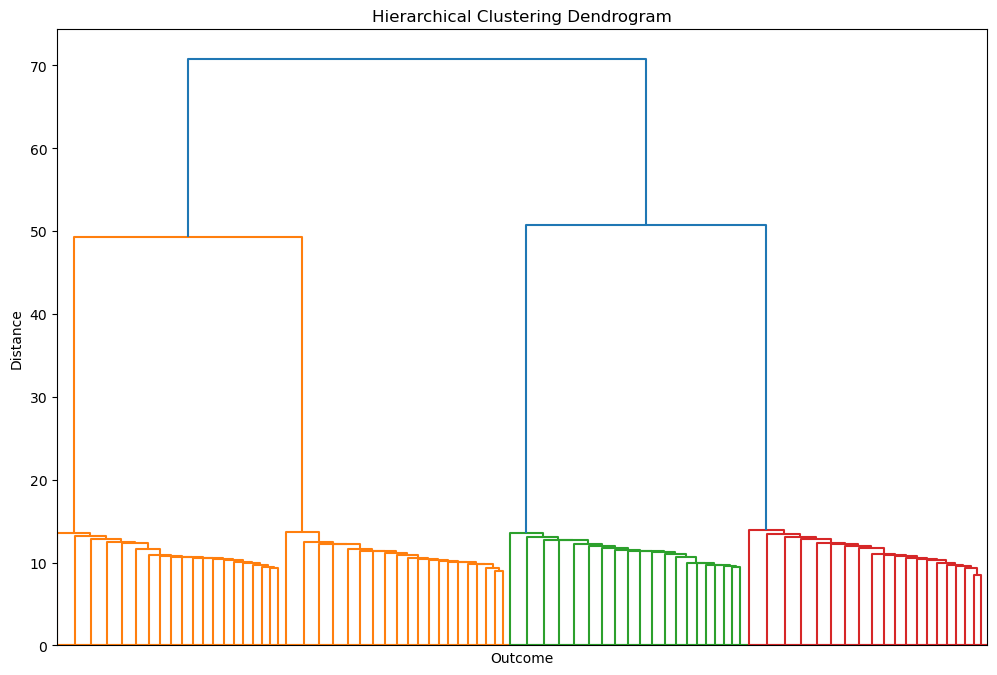

In [99]:
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Outcome')
plt.ylabel('Distance')
dendrogram(hcw, no_labels=True)
plt.show()

      transaction_date transaction_status  burn_date  join_date   city_name  \
0               -18263         subscribed     -18263     -18263       Aswan   
1               -18263             burned     -18263     -18263    Damietta   
2               -18263         subscribed     -18263     -18263  Alexandria   
3               -18263         subscribed     -18263     -18263       Aswan   
4               -18263             burned     -18263     -18263    Damietta   
...                ...                ...        ...        ...         ...   
4995            -18263         subscribed     -18263     -18263      Fayyum   
4996            -18263         subscribed     -18263     -18263   Port Said   
4997            -18263             burned     -18263     -18263       Asyut   
4998            -18263             burned     -18263     -18263   Port Said   
4999            -18263         subscribed     -18263     -18263       Minya   

     gender_name clusters  
0         Female  Group

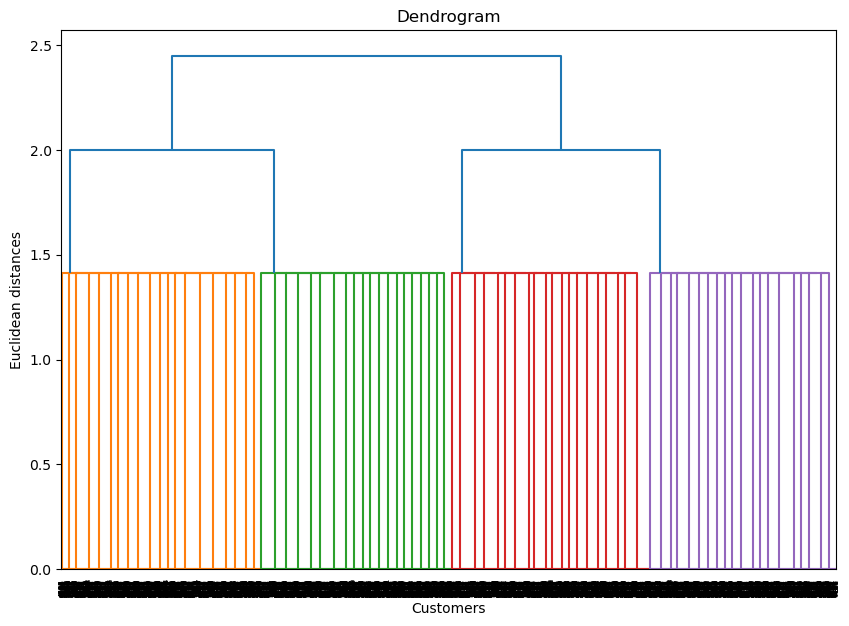

In [100]:
# Assign clusters (e.g., 2 clusters)
clusters = fcluster(hcc, 2, criterion='maxclust')

# Map cluster labels to meaningful categories
cluster_map = {1: 'Group 1', 2: 'Group 2'}
data['clusters'] = [cluster_map[cluster] for cluster in clusters]

# Print the resulting clusters
print(data[['transaction_date', 'transaction_status', 'burn_date', 'join_date', 'city_name', 'gender_name', 'clusters']])

# Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(hcc)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()